# Fraud Detection System - V1: Exploratory Data Analysis (EDA)

**Date:** 2026-02-18    
**Author:** *Luis Renteria Lezano*  
[LinkedIn](https://www.linkedin.com/in/renteria-luis) | [GitHub](https://github.com/renteria-luis)

## Executive Summary
- **Goal:** This project focuses on identifying fraudulent financial transactions using the PaySim synthetic dataset. Unlike previous iterations relying on anonymized PCA features, this version prioritizes **financial interpretability** and data integrity to ensure the model is production-ready.
- **Key Refactor Note:** This version transitions from black-box features to a transparent feature engineering pipeline. We corrected a significant simulation artifact where legitimate traffic collapsed in the final hours, ensuring the model learns behavioral patterns rather than dataset timestamps.
- **Source:** This analysis uses the Credit Card Fraud Detection dataset published on [Synthetic Financial Datasets For Fraud Detection](https://www.kaggle.com/datasets/ealaxi/paysim1).
- **Target variable:** `isFraud`:
    - 0 = legitimate transaction
    - 1 = fraudulent transaction

## 1. Reproducibility & Environment Setup
- Pin versions in [`../requirements.txt`](../).
- Keep raw data immutable [`../data/raw/`](../data/raw/).

In [1]:
%reload_ext autoreload
%autoreload 2

import sys
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp

from sklearn.model_selection import train_test_split

sys.path.append('..')
from src.data.loader import load_paysim, filter_and_clean
from src.features.engineering import PaySimFeatures

# 1. Global Reproducibility
SEED = 42
np.random.seed(SEED)

# 2. Path Management
BASE_DIR = Path("..")
ASSETS_DIR = Path('../assets/figures')
DATA_RAW = BASE_DIR / "data" / "raw"
DATA_PROCESSED = BASE_DIR / "data" / "processed"
MODELS_DIR = BASE_DIR / "models"
MODELS_DIR = BASE_DIR / "models"

# 3. Plotting Style
sns.set_theme(style='whitegrid', context='notebook', palette='viridis')
plt.rcParams["figure.figsize"] = (10, 6)

# 4. Global Settings
pd.set_option('display.max_columns', 50)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

## 2. Data Loading & Overview
### 2.1 Load Data

In [2]:
raw_file = DATA_RAW / 'PS_20174392719_1491204439457_log.csv'
df = pd.read_csv(raw_file)

### 2.2 Dataset Shape & Info

In [3]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


### 2.3 First Rows Preview

In [4]:
df.head(3)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.640,C1231006815,170136.000,160296.360,M1979787155,0.000,0.000,0,0
1,1,PAYMENT,1864.280,C1666544295,21249.000,19384.720,M2044282225,0.000,0.000,0,0
2,1,TRANSFER,181.000,C1305486145,181.000,0.000,C553264065,0.000,0.000,1,0


### 2.4 Feature Exploration

In [5]:
for col in df.columns:
    # Ignore floats
    if pd.api.types.is_float_dtype(df[col]):
        continue
    n_unique = df[col].nunique()
    
    if n_unique > 10:
        print(f"{col}: high cardinality ({n_unique} unique values)")
    else:
        print(f"{col}: {n_unique} unique values -> {df[col].unique()}")

step: high cardinality (743 unique values)
type: 5 unique values -> ['PAYMENT' 'TRANSFER' 'CASH_OUT' 'DEBIT' 'CASH_IN']
nameOrig: high cardinality (6353307 unique values)
nameDest: high cardinality (2722362 unique values)
isFraud: 2 unique values -> [0 1]
isFlaggedFraud: 2 unique values -> [0 1]


**Findings (PaySim 1):**

* `step`: time step in hours since the first transaction.
* `type`: type of transaction (*CASH-IN*, *CASH-OUT*, *TRANSFER*, *DEBIT*, *PAYMENT*).
* `amount`: transaction amount.
* `nameOrig`: ID of the customer who initiates the transaction (high cardinality -> dropped).
* `nameDest`: ID of the customer who receives the transaction (high cardinality -> dropped).
* `oldbalanceOrg`: balance of the origin account before the transaction.
* `newbalanceOrig`: balance of the origin account after the transaction (data leakage -> dropped).
* `oldbalanceDest`: balance of the destination account before the transaction.
* `newbalanceDest`: balance of the destination account after the transaction (data leakage -> dropped).
* `isFraud`: 0 (legitimate) / 1 (fraud).
* `isFlaggedFraud`: 0/1, automatically flagged by business rules (rare, mostly 0 -> dropped).

In [6]:
duplicates = df.duplicated().sum()

if duplicates > 0:
    print(f'There are {duplicates} duplicated rows in the dataset.')
    df = df.drop_duplicates()
else:
    print('There are no duplicates in the dataset.')

There are no duplicates in the dataset.


## 3. Data Quality Assessment
### 3.1 Missing Values

In [7]:
missing_per_col = df.isna().sum()

if missing_per_col.sum() > 0:
    missing_per_col[missing_per_col > 0].sort_values(ascending=False).head()
else:
    print('There are no missing values in the dataset.')

There are no missing values in the dataset.


### 3.2 Duplicated Values

In [8]:
duplicates = df.duplicated().sum()

if duplicates > 0:
    print(f'There are {duplicates} duplicated rows in the dataset.')
    df = df.drop_duplicates()
else:
    print('There are no duplicates in the dataset.')

There are no duplicates in the dataset.


## 4. Target Variable Analysis (Class Imbalance)
### 4.1 Class Distribution

In [9]:
counts = df['isFraud'].value_counts()
percent = df['isFraud'].value_counts(normalize=True) * 100

summary = pd.DataFrame({
    'Count': counts,
    'Percentage': percent
}).reset_index()

summary.rename(columns={'index': 'isFraud'}, inplace=True)
summary

,isFraud,Count,Percentage
0,0,6354407,99.871
1,1,8213,0.129


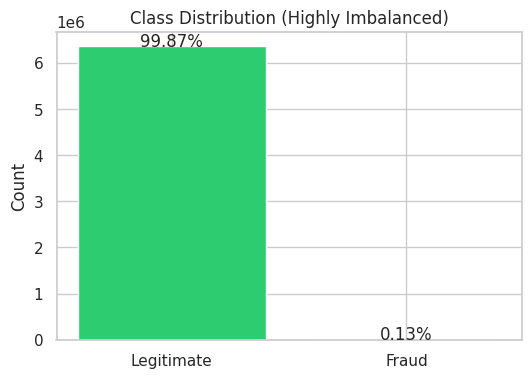

In [10]:
fig, ax = plt.subplots(figsize=(6,4))

class_counts = df['isFraud'].value_counts()
class_counts = class_counts.reindex([0,1])

ax.bar(['Legitimate', 'Fraud'], class_counts.values, color=['#2ecc71', '#e74c3c'])
ax.set_ylabel('Count')
ax.set_title('Class Distribution (Highly Imbalanced)')

for i, count in enumerate(class_counts.values):
    pct = 100 * count / class_counts.values.sum()
    ax.text(i, count + 100, f"{pct:.2f}%", ha='center')

# plt.savefig(ASSETS_DIR / 'class_distribution.png', dpi=100, bbox_inches='tight')
plt.show()
# plt.close()

### 4.2 Imbalance Ratio

In [11]:
# imbalance_ratio = legitimate / fraud
print(f"For every fraudulent transaction, there are {int(summary.loc[0, 'Count'] / summary.loc[1, 'Count'])} legitimate transactions.")

For every fraudulent transaction, there are 773 legitimate transactions.


**Implication for modeling:**
- Accuracy is useless metric (99.8% by predicting all 0)
- Focus on Precision, Recall, F1, ROC-AUC, AUPRC
- Stratified split essential



## 5. Feature Analysis
### 5.1. Type feature

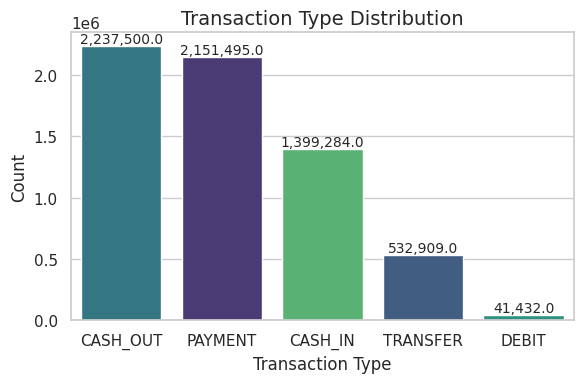

In [12]:
plt.figure(figsize=(6,4))
sns.countplot(
    data=df,
    x='type',
    hue='type',
    order=df['type'].value_counts().index  # sorts
)
plt.title('Transaction Type Distribution', fontsize=14)
plt.xlabel('Transaction Type', fontsize=12)
plt.ylabel('Count', fontsize=12)

# show counts
for p in plt.gca().patches:
    height = p.get_height()
    plt.gca().annotate(f'{height:,}', 
                       (p.get_x() + p.get_width() / 2., height),
                       ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

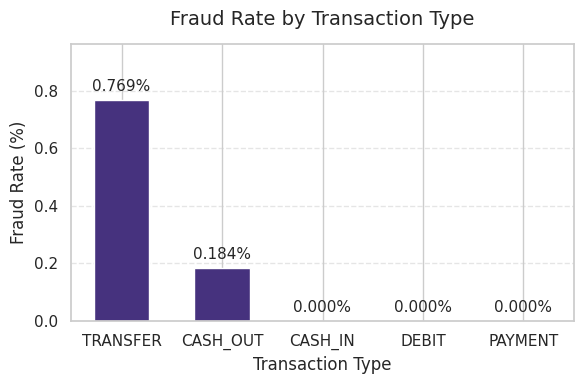

In [13]:
fraud_rate = (
    df.groupby("type")["isFraud"]
    .mean()
    .mul(100)
    .reset_index()
    .rename(columns={"isFraud": "fraud_pct"})
    .sort_values("fraud_pct", ascending=False)
)

fig, ax = plt.subplots(figsize=(6, 4))
bars = ax.bar(fraud_rate["type"], fraud_rate["fraud_pct"], width=0.55)

for bar, val in zip(bars, fraud_rate["fraud_pct"]):
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 0.02,
        f"{val:.3f}%",
        ha="center", va="bottom",
        fontsize=11
    )

ax.set_title("Fraud Rate by Transaction Type", fontsize=14, pad=14)
ax.set_xlabel("Transaction Type", fontsize=12)
ax.set_ylabel("Fraud Rate (%)", fontsize=12)
ax.set_ylim(0, fraud_rate["fraud_pct"].max() * 1.25)
ax.grid(axis="y", linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()

**Insight:**

* **TRANSFER transactions** have the highest fraud rate at **0.769%**, even though they are less frequent than CASH-OUT or PAYMENT.
* **CASH-OUT transactions** also show some fraud, at **0.184%**, but lower than TRANSFER.
* **CASH-IN, PAYMENT, and DEBIT** transactions have **0% fraud**, meaning no fraudulent activity was observed in these categories.

**Action:**

* The records corresponding to **CASH-IN, PAYMENT, and DEBIT** will be removed from the dataset, since they contain no fraud and do not contribute to modeling or detecting fraud.
* After removing CASH-IN, PAYMENT, and DEBIT, we are left with **2,770,409 records**.

### 5.2 Time feature

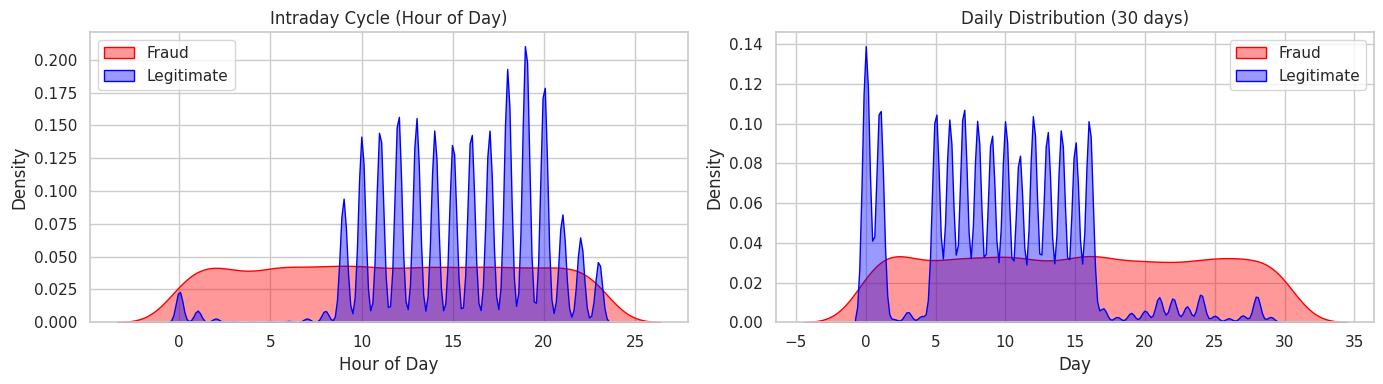

In [14]:
df['hour_of_day'] = df['step'] % 24
df['day'] = df['step'] // 24

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# hourly
sns.kdeplot(
    data=df, x='hour_of_day', hue='isFraud',
    common_norm=False, fill=True, alpha=0.4,
    hue_order=[0, 1], palette={0: 'blue', 1: 'red'}, ax=axes[0]
)
axes[0].set_title('Intraday Cycle (Hour of Day)')
axes[0].set_xlabel('Hour of Day')
axes[0].set_ylabel('Density')
axes[0].legend(labels=['Fraud', 'Legitimate'])

# daily
sns.kdeplot(
    data=df, x='day', hue='isFraud',
    common_norm=False, fill=True, alpha=0.4,
    hue_order=[0, 1], palette={0: 'blue', 1: 'red'}, ax=axes[1]
)
axes[1].set_title('Daily Distribution (30 days)')
axes[1].set_xlabel('Day')
axes[1].set_ylabel('Density')
axes[1].legend(labels=['Fraud', 'Legitimate'])

plt.tight_layout()
plt.savefig(ASSETS_DIR / 'time_distribution.png', dpi=100, bbox_inches='tight')
plt.show()
plt.close()

**Time Insights:**
- **Fraud is Time-Agnostic**
   Legit transactions follow a human circadian cycle; fraud is flat, likely driven by bots. Transactions at 2–5 AM are far more likely fraudulent.
- **Deviation from Human Patterns**
   Legit activity has sharp, regular spikes (“comb effect”). Any deviation signals anomaly; fraud ignores these rhythms.
- **Daily Persistence**
   Legit transactions drop after day 17, fraud stays constant. The last 3–4 days have no legit transactions, so they will be removed; otherwise the model would always predict fraud for these days. This also prevents temporal overfitting.
- **Feature Engineering**
   Hour is highly predictive; encode cyclically (sine/cosine). Fraud is dispersed; legit clusters — anomaly detection can exploit this.

## 6. Feature Engineering
`hour_of_day`: hour of day derived from time step.  
`day`: day index derived from elapsed steps.  
`amount_to_orig_balance`: amount relative to origin balance before transaction.  
`amount_to_dest_balance`: amount relative to destination balance before transaction.  
`dest_account_empty_before`: indicator if destination was empty before transaction.  

In [15]:
# We use our functions to clean the dataset & perform FE
X, y = filter_and_clean(df)
fe = PaySimFeatures(cyclical_encoding=True)
X_fe = fe.fit_transform(X)

X_fe.head()

,type,amount,oldbalanceOrg,oldbalanceDest,hour_of_day,day,hour_sin,hour_cos,amount_log,amount_to_orig_balance,amount_to_dest_balance,dest_account_empty_before
2,TRANSFER,181.000,181.000,0.000,1,0,0.259,0.966,5.204,0.995,181.000,1
3,CASH_OUT,181.000,181.000,21182.000,1,0,0.259,0.966,5.204,0.995,0.009,0
15,CASH_OUT,229133.940,15325.000,5083.000,1,0,0.259,0.966,12.342,14.951,45.070,0
19,TRANSFER,215310.300,705.000,22425.000,1,0,0.259,0.966,12.280,304.972,9.601,0
24,TRANSFER,311685.890,10835.000,6267.000,1,0,0.259,0.966,12.650,28.764,49.727,0


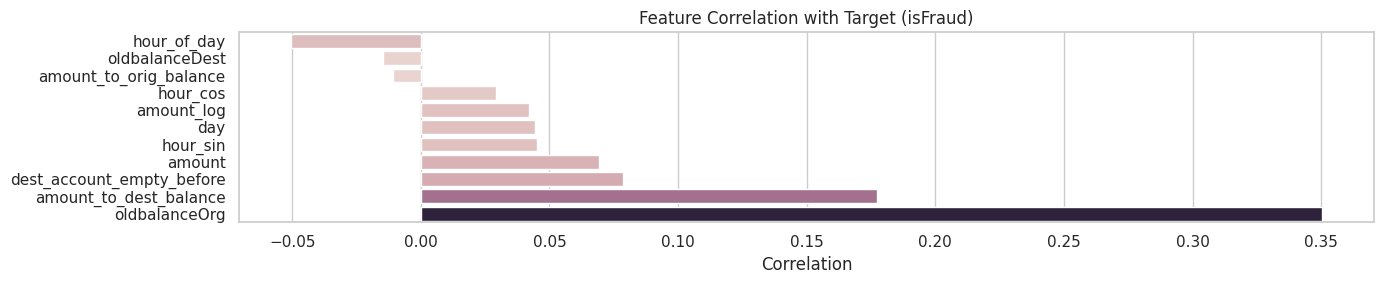

In [16]:
X_num = X_fe.select_dtypes(include=[np.number])
corr = X_num.corrwith(y)

corr_df = (corr.rename("correlation").reset_index().rename(columns={"index": "feature"}))

# style & sorting
corr_df["abs_corr"] = corr_df["correlation"].abs()
corr_df = corr_df.sort_values("correlation")

plt.figure(figsize=(14, 3))
sns.barplot(
    data=corr_df,
    x="correlation",
    y="feature",
    hue="abs_corr",
    legend=False
)
plt.title("Feature Correlation with Target (isFraud)")
plt.xlabel("Correlation")
plt.ylabel("")
plt.tight_layout()
plt.show()

## 7. Final Class Distribution

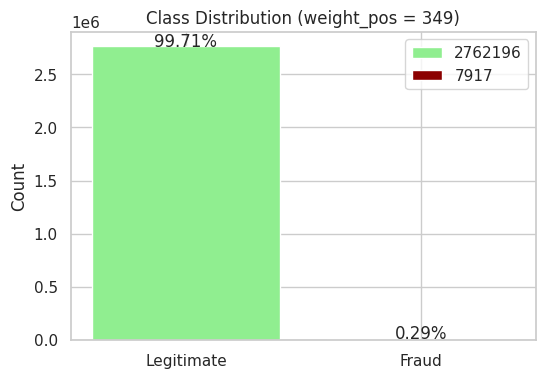

In [49]:
fig, ax = plt.subplots(figsize=(6, 4))
class_counts = y.value_counts().reindex([0, 1])

bars = ax.bar(['Legitimate', 'Fraud'], class_counts.values, color=['lightgreen', 'darkred'])
ax.set_ylabel('Count')
ax.set_title(f'Class Distribution (weight_pos = {round((y == 0).sum()/(y == 1).sum())})')

for i, count in enumerate(class_counts.values):
    pct = 100 * count / class_counts.values.sum()
    ax.text(i, count + 100, f"{pct:.2f}%", ha='center')

total_rows = len(y)
ax.legend(bars, [f"{count}" for label, count in zip(['Legitimate', 'Fraud'], class_counts.values)])

plt.savefig(ASSETS_DIR / 'class_distribution.png', dpi=100, bbox_inches='tight')
plt.show()
plt.close()

## 8. EDA Conclusions & Next Steps
**Key Findings:**  
- **Transaction Segmentation:** Fraudulent activity is exclusively tied to `TRANSFER` (0.769% fraud rate) and `CASH_OUT` (0.184%) operations. All other types (`PAYMENT`, `CASH_IN`, `DEBIT`) were removed to eliminate noise and sharpen the fraud signal.
- **Bot-Driven Behavior (Temporal Invariance):** While legitimate transactions follow a human circadian cycle manifesting as a "comb effect" in density plots fraudulent activity is remarkably flat and constant. Transactions occurring between 2:00 AM and 5:00 AM exhibit a disproportionately higher risk.
- **Prevention of Data Leakage:** Features such as `newbalanceOrig`, `newbalanceDest`, and `isFlaggedFraud` were discarded. These columns contain post-event information or internal business rules that would artificially inflate model performance during training.
- **Temporal Consistency (The "Hachazo"):** A critical audit revealed that legitimate transactions cease after step 718, while fraud continues until step 743. The dataset was truncated at step 718 to prevent the model from learning a false correlation between "late-month" timestamps and fraud.
- **Balance Anomalies:** High-cardinality identifiers (`nameOrig`, `nameDest`) were dropped in favor of behavioral ratios, such as `amount_to_balance`, which better capture the intent of a transaction.

**Modeling Strategy:**  
- **Out-of-Time (OOT) Validation:** We reject standard random shuffling. A **chronological split (80/20)** will be implemented to train on past data and validate on the "future" (final steps), mimicking a real-world deployment scenario.
- **Feature Engineering Pipeline [/src/features/engineering.py](../src/features/engineering.py):**
  - **Temporal:** Sine/Cosine encoding for `hour_of_day` to preserve cyclical proximity.
  - **Monetary:** $Log(1+x)$ transformation for `amount` to mitigate extreme right-skewness.
- **Success Metrics:** Accuracy is discarded due to the extreme 349:1 imbalance. Performance will be judged on **AUPRC** (Area Under the Precision-Recall Curve) and **Recall**, ensuring we capture the maximum amount of fraud while maintaining acceptable false-positive rates.
- **Imbalance Handling:** Models will utilize `scale_pos_weight` (XGBoost) or cost-sensitive learning to account for the minority class.

The baseline modeling phase will proceed in [02_baseline_models.ipynb]('./02_baseline_models.ipynb') using XGBoost's histogram-based tree method for memory efficiency.